In [ ]:
# importing and installing library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
!pip install implicit
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV
from implicit.als import AlternatingLeastSquares
from sklearn.metrics import mean_squared_error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 19.8 MB/s eta 0:00:00


Events Data Analysis :

In [ ]:
event_data = pd.read_csv('/content/events.csv')

In [ ]:
event_data.shape

(2756101, 5)

In [ ]:
event_data.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN




1. The timestamp portion is time at which user was on platform.
2. Visitor Id is the unique user currently browsing the website
3. Event is what the user is currently doing in that current timestamp
4. Transaction ID will only have value if the user made a purchase as shown below.

In [ ]:
#sort event because events take place one by one with respect to time

event_data = event_data.sort_values(by=['visitorid', 'timestamp']).reset_index(drop=True)
event_data.head()

,timestamp,visitorid,event,itemid,transactionid
0,1442004589439,0,view,285930,NaN
1,1442004759591,0,view,357564,NaN
2,1442004917175,0,view,67045,NaN
3,1439487966444,1,view,72028,NaN
4,1438969904567,2,view,325215,NaN


In [ ]:
uniq_visitor = event_data['visitorid'].nunique()
total_visitor = event_data['visitorid'].size

print(f'total visitor:{total_visitor}')
print(f'unique visitor:{uniq_visitor}')

total visitor:2756101
unique visitor:1407580


In [ ]:
#check null values

event_data.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [ ]:
#check how many item customer purchased

customer_purchased = event_data[event_data['transactionid'].notnull()].visitorid.nunique()
customer_purchased

11719

In [ ]:
#check duplicates

event_data.duplicated().sum()

460

In [ ]:
#remove duplicates

event_data.drop_duplicates(keep='first', inplace=True)

In [ ]:
#check value count of event column

event_count = event_data['event'].value_counts()
event_count

event
view           2664218
addtocart        68966
transaction      22457
Name: count, dtype: int64

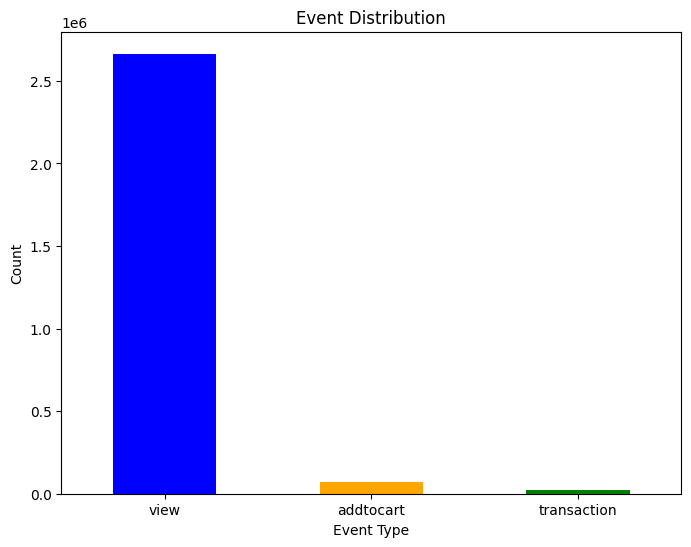

In [ ]:
#visualizing event distribution
plt.figure(figsize=(8, 6))
event_data['event'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Event Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

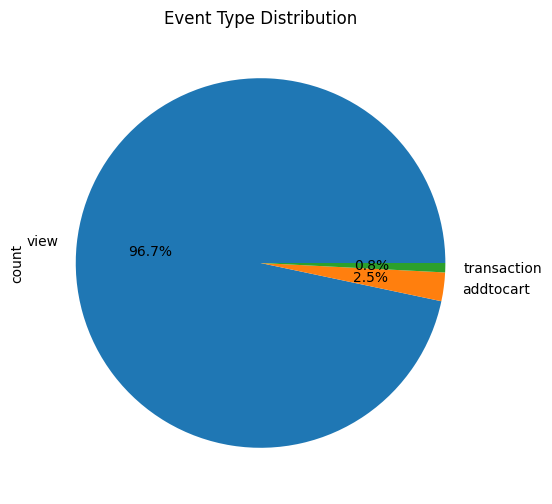

In [ ]:
#percentage wise distribution showed

event_percentage = event_count / len(event_data)
plt.figure(figsize=[6,6])
event_percentage.plot(kind='pie', autopct='%1.1f%%')
plt.title('Event Type Distribution')
plt.show()

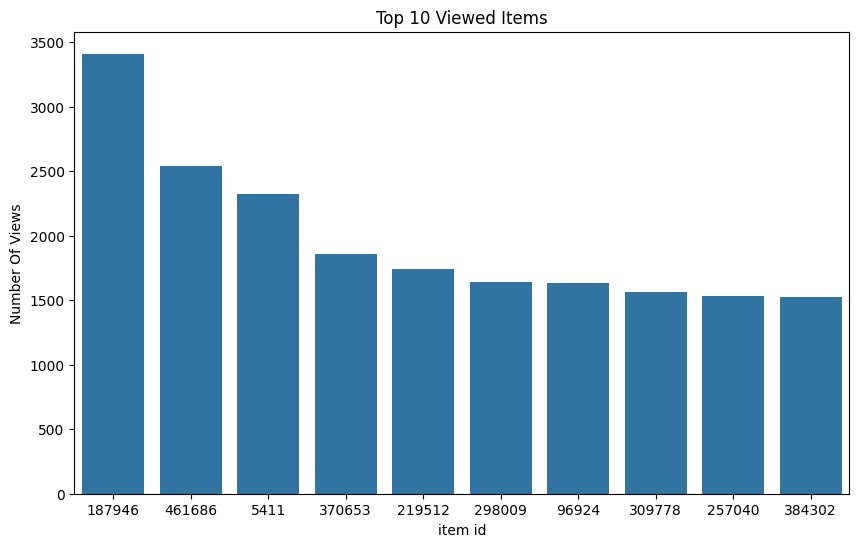

In [ ]:
# top viewed items

top_viewed_items = event_data[event_data['event']=='view']['itemid'].value_counts().head(10)
top_viewed_items = top_viewed_items.sort_values(ascending= False)
plt.figure(figsize=(10,6))
sns.barplot(x=top_viewed_items.index, y=top_viewed_items.values, order = top_viewed_items.index)
plt.title('Top 10 Viewed Items')
plt.xlabel('item id')
plt.ylabel('Number Of Views')
plt.show()

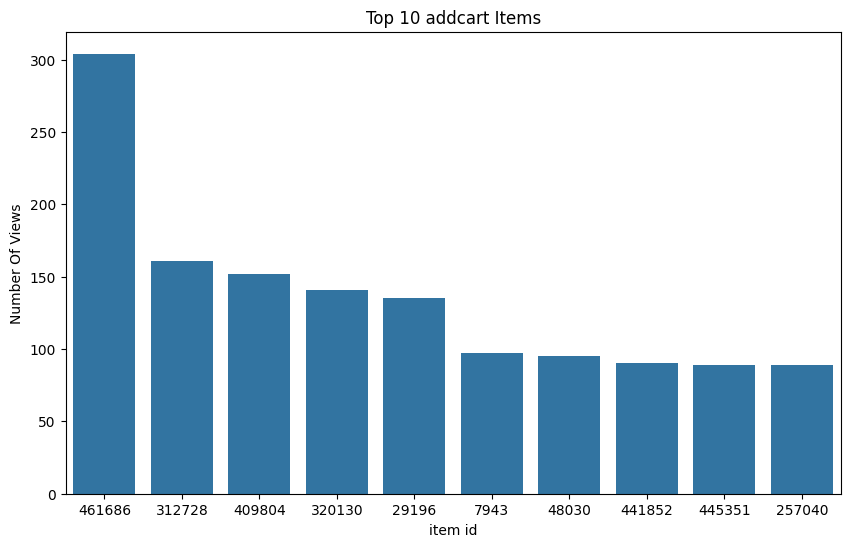

In [ ]:
# top items added to cart

top_addcart_items = event_data[event_data['event']=='addtocart']['itemid'].value_counts().head(10)
top_addcart_items = top_addcart_items.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=top_addcart_items.index, y=top_addcart_items.values, order=top_addcart_items.index)
plt.title('Top 10 addcart Items')
plt.xlabel('item id')
plt.ylabel('Number Of Views')
plt.show()

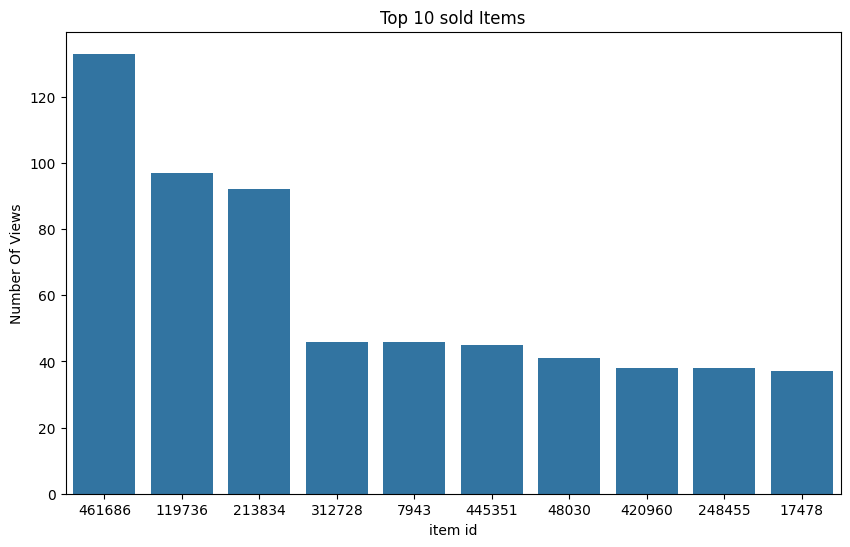

In [ ]:
#top sold items

top_sold_items = event_data[event_data['event']=='transaction']['itemid'].value_counts().head(10)
top_sold_items = top_sold_items.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=top_sold_items.index, y=top_sold_items.values, order=top_sold_items.index)
plt.title('Top 10 sold Items')
plt.xlabel('item id')
plt.ylabel('Number Of Views')
plt.show()

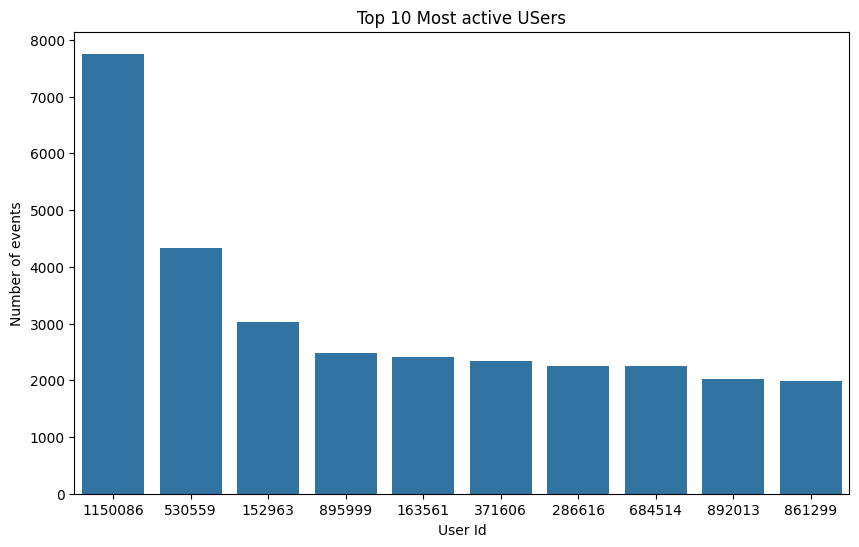

In [ ]:
# few most active users

top_active_users=event_data['visitorid'].value_counts().head(10)
top_active_users = top_active_users.sort_values(ascending=False)


plt.figure(figsize=(10,6))
sns.barplot(x=top_active_users.index, y=top_active_users.values, order=top_active_users.index)
plt.title('Top 10 Most active USers')
plt.xlabel('User Id')
plt.ylabel('Number of events')
plt.show()

#collaborative filtering : item-based:

We want to suggest the User a item, that may be added to the cart. Based on item based collaborative filtering.

PRE-PROCESSING

In [ ]:
#creating new dataframe to aggregate and organize the event data by visitor, item, and event type,
#providing a more structured and condensed representation of the information for further analysis

visitor_item_event_df = event_data.groupby(['visitorid', 'itemid', 'event'])['timestamp'].count().to_frame().reset_index()
visitor_item_event_df.head()

,visitorid,itemid,event,timestamp
0,0,67045,view,1
1,0,285930,view,1
2,0,357564,view,1
3,1,72028,view,1
4,2,216305,view,2


In [ ]:
visitor_item_event_df.shape

(2215422, 4)

In [ ]:
# T0 make things run faster lets sample few items

np.random.seed(1)
items_to_keep = np.random.choice(visitor_item_event_df['itemid'].unique(), size=100000, replace=False)
visitor_item_event_df = visitor_item_event_df[visitor_item_event_df['itemid'].isin(items_to_keep)]

In [ ]:
#lets get addtocart event only

visitor_item_df = visitor_item_event_df[visitor_item_event_df['event'] == 'addtocart']
visitor_item_df.head()

,visitorid,itemid,event,timestamp
207,155,41882,addtocart,1
213,155,181405,addtocart,1
215,155,368372,addtocart,1
217,155,389974,addtocart,1
379,264,161949,addtocart,1


In [ ]:
visitor_item_df.shape

(26785, 4)

CREATE METRICS

In [ ]:
#convert long data into wide range for details of user based colaborative

item_wise_df = visitor_item_df.pivot(index='itemid', columns='visitorid', values='timestamp')
item_wise_df

visitorid,155,264,419,420,539,588,627,648,795,878,...,1407037,1407059,1407064,1407070,1407110,1407129,1407355,1407430,1407512,1407515
itemid,,,,,,,,,,,,,,,,,,,,,
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
466688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


MEAN CENTERING:
AS WE SEE LOT OF NAN VALUE AVAILBLE IN OUR DATASET SO TO NORMALIZE AND ADDRESSING SPARSITY FILLING MISSING VALUE WITH NEUTRAL SCORES BY PERFORMING MEAN CENTERING

In [ ]:
#subtracting the mean of the addtocart from each individual data point

avg_addcarts = item_wise_df.sum() / item_wise_df.shape[1]
visitor_item_raw_df = item_wise_df.copy()
item_wise_df = item_wise_df.sub(avg_addcarts, axis=1)
item_wise_df = item_wise_df.fillna(0)
item_wise_df.head()

visitorid,155,264,419,420,539,588,627,648,795,878,...,1407037,1407059,1407064,1407070,1407110,1407129,1407355,1407430,1407512,1407515
itemid,,,,,,,,,,,,,,,,,,,,,
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#we addressed that our data has sparsity so calculating sparsity percentage

not_empty = visitor_item_raw_df.notnull().values.sum()
total_number = visitor_item_raw_df.size
print(100 * not_empty/total_number)

0.014052655828659695


This suggests that 99.86% of the entries in our DataFrame are empty or missing. so we will not able to recommend items using KNN so will use ALTERNATE LEAST SQUARE Model but before that we will check cosine similarity between item for better recommendations.

COSINE SIMILARITY

In [ ]:
#finding similarities based on item-wise

similarities = cosine_similarity(item_wise_df)
consine_similarity_df = pd.DataFrame(similarities,
                                    index=item_wise_df.index.values,
                                    columns=item_wise_df.index.values)
consine_similarity_df.head()

,25,33,66,168,212,216,233,315,350,361,...,466301,466335,466385,466464,466472,466614,466685,466688,466710,466747
25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#lets check similar products to itemid 2416

consine_similarity_df[461686].sort_values(ascending=False).head(10)

461686    1.000000
171878    0.309607
198041    0.291444
32581     0.282786
40630     0.238182
362495    0.205020
95914     0.193517
199394    0.193517
279257    0.193517
361152    0.193517
Name: 461686, dtype: float64

MATRIX FACTORIZATION:

***Alternating Least Squares

In [ ]:
# Convert DataFrame to Sparse Matrix

item_wise_sparse = csr_matrix(item_wise_df)

In [ ]:
# Generate Train and Test Data

np.random.seed(42)
mask = np.random.choice([False, True], size=item_wise_df.shape, p=[0.2, 0.8])
train_data = np.where(mask, item_wise_sparse.A, 0)
test_data = np.where(~mask, item_wise_sparse.A, 0)

In [ ]:
# Convert the training data to CSR matrix

train_data_csr = csr_matrix(train_data.T)

In [ ]:
# Initialize and train the ALS model

model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=10)
model.fit(train_data_csr)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

EVOLUTION METRICS

In [ ]:
# Predict missing values in the test data
predicted_matrix = model.item_factors.dot(model.user_factors.T)

# Evaluate the model
mse = mean_squared_error(test_data[test_data != 0], predicted_matrix[test_data != 0])
print(mse)

1.3927918952014913


OBSERVATION :

The MSE provides a quantitative measure of the model's performance, indicating how well the predicted interactions align with the actual interactions in the test data.